Selected neural columns: ['dF_F_roi0', 'dF_F_roi1', 'dF_F_roi2', 'dF_F_roi3', 'dF_F_roi4', 'dF_F_roi5', 'dF_F_roi6', 'dF_F_roi7', 'dF_F_roi8', 'dF_F_roi9', 'dF_F_roi10', 'dF_F_roi11', 'dF_F_roi12', 'dF_F_roi13', 'dF_F_roi14', 'dF_F_roi15', 'dF_F_roi16', 'dF_F_roi17', 'dF_F_roi18', 'dF_F_roi19', 'dF_F_roi20', 'dF_F_roi21', 'dF_F_roi22', 'dF_F_roi23', 'dF_F_roi24', 'dF_F_roi25', 'dF_F_roi26', 'dF_F_roi27', 'dF_F_roi28', 'dF_F_roi29', 'dF_F_roi30', 'dF_F_roi31', 'dF_F_roi32', 'dF_F_roi33', 'dF_F_roi34', 'dF_F_roi35', 'dF_F_roi36', 'dF_F_roi37', 'dF_F_roi38', 'dF_F_roi39', 'dF_F_roi40', 'dF_F_roi41', 'dF_F_roi42', 'dF_F_roi43', 'dF_F_roi44', 'dF_F_roi45', 'dF_F_roi46', 'dF_F_roi47', 'dF_F_roi48', 'dF_F_roi49', 'dF_F_roi50', 'dF_F_roi51', 'dF_F_roi52', 'dF_F_roi53', 'dF_F_roi54', 'dF_F_roi55', 'dF_F_roi56', 'dF_F_roi57', 'dF_F_roi58', 'dF_F_roi59', 'dF_F_roi60', 'dF_F_roi61', 'dF_F_roi62', 'dF_F_roi63', 'dF_F_roi64', 'dF_F_roi65', 'dF_F_roi66', 'dF_F_roi67', 'dF_F_roi68', 'dF_F_roi69', 'dF_

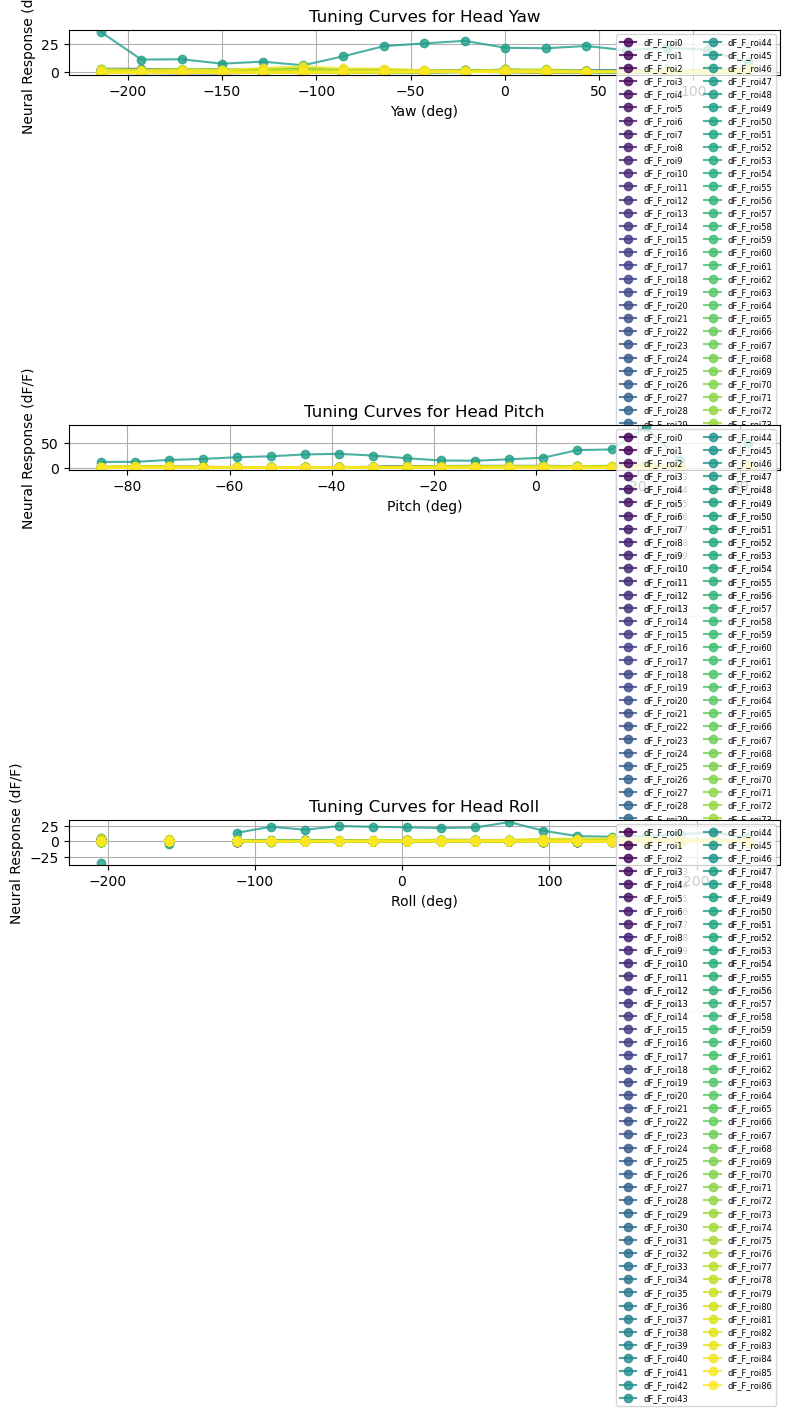

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import matplotlib.cm as cm

# -----------------------------------
# 1. Load Data and Compute Angles
# -----------------------------------

# Adjust the path as needed.
hdf5_file_path = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_17_05/MIR_Aligned/aligned_predictions_with_ca_and_dF_F.h5"
df = pd.read_hdf(hdf5_file_path, key='df')

# Define keypoint labels (1-indexed)
keypoint_labels = [
    'EarL',       # 1
    'EarR',       # 2
    'Snout',      # 3
    'SpineF',     # 4
    'SpineM',     # 5
    'Tail(base)', # 6
    'Tail(mid)',  # 7
    'Tail(end)',  # 8
    'ForepawL',   # 9
    'WristL',     # 10
    'ElbowL',     # 11
    'ShoulderL',  # 12
    'ForepawR',   # 13
    'WristR',     # 14
    'ElbowR',     # 15
    'ShoulderR',  # 16
    'HindpawL',   # 17
    'AnkleL',     # 18
    'KneeL',      # 19
    'HindpawR',   # 20
    'AnkleR',     # 21
    'KneeR'       # 22
]

def normalize(v):
    norm = np.linalg.norm(v)
    if norm < 1e-8:
        return v
    return v / norm

def compute_euler_angles_from_row(row):
    """Compute head Euler angles (relative to body) from a single DataFrame row."""
    # Helper to get a keypoint vector (using 1-indexing)
    def get_kp(idx):
        return np.array([row[f'kp{idx}_x'], row[f'kp{idx}_y'], row[f'kp{idx}_z']])
    
    # --- Head coordinate frame (using EarL (1), EarR (2), Snout (3)) ---
    earL = get_kp(1)
    earR = get_kp(2)
    snout = get_kp(3)
    ear_mid = (earL + earR) / 2.0
    head_x = normalize(snout - ear_mid)
    temp_y = earR - earL
    head_y = normalize(temp_y - np.dot(temp_y, head_x) * head_x)
    head_z = normalize(np.cross(head_x, head_y))
    
    # --- Body coordinate frame (using SpineF (4), SpineM (5), ShoulderL (12), ShoulderR (16)) ---
    spineF = get_kp(4)
    spineM = get_kp(5)
    shoulderL = get_kp(12)
    shoulderR = get_kp(16)
    body_x = normalize(spineF - spineM)
    shoulder_vec = shoulderR - shoulderL
    body_y = normalize(shoulder_vec - np.dot(shoulder_vec, body_x) * body_x)
    body_z = normalize(np.cross(body_x, body_y))
    
    # Construct rotation matrices and compute relative rotation (body -> head)
    R_body = np.column_stack((body_x, body_y, body_z))
    R_head = np.column_stack((head_x, head_y, head_z))
    R_rel = np.dot(R_body.T, R_head)
    
    # Convert to Euler angles (yaw, pitch, roll) in degrees
    euler_angles = R.from_matrix(R_rel).as_euler('xyz', degrees=True)
    return euler_angles  # [Yaw, Pitch, Roll]

# Precompute Euler angles for all frames.
nframes = len(df)
yaw_vals   = np.empty(nframes)
pitch_vals = np.empty(nframes)
roll_vals  = np.empty(nframes)
for i in range(nframes):
    row = df.iloc[i]
    euler = compute_euler_angles_from_row(row)
    yaw_vals[i]   = euler[0]
    pitch_vals[i] = euler[1]
    roll_vals[i]  = euler[2]

yaw_vals = np.degrees(np.unwrap(np.radians(yaw_vals)))
pitch_vals = np.degrees(np.unwrap(np.radians(pitch_vals)))
roll_vals = np.degrees(np.unwrap(np.radians(roll_vals)))


# -----------------------------------
# 2. Select Neural Data Columns
# -----------------------------------

neural_columns = [col for col in df.columns if col.startswith('dF_F_roi')]
print("Selected neural columns:", neural_columns)

# -----------------------------------
# 3. Compute Tuning Curves
# -----------------------------------

def compute_tuning_curve(angle_vals, neural_vals, nbins=20):
    """
    Bin the angle values and compute the mean neural response within each bin.
    """
    bins = np.linspace(np.min(angle_vals), np.max(angle_vals), nbins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2.0
    avg_response = np.zeros(nbins)
    for i in range(nbins):
        mask = (angle_vals >= bins[i]) & (angle_vals < bins[i+1])
        if np.any(mask):
            avg_response[i] = np.mean(neural_vals[mask])
        else:
            avg_response[i] = np.nan
    return bin_centers, avg_response

# # -----------------------------------
# # 4. Plot All Neurons' Tuning Curves for Yaw, Pitch, and Roll
# # -----------------------------------

# Prepare a colormap
n_neurons = len(neural_columns)
colors = cm.viridis(np.linspace(0, 1, n_neurons))

fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=False)

angle_names = ['Yaw', 'Pitch', 'Roll']
angle_values_list = [yaw_vals, pitch_vals, roll_vals]

for ax, angle_name, angle_vals in zip(axes, angle_names, angle_values_list):
    for i, neuron in enumerate(neural_columns):
        neural_vals = df[neuron].values
        centers, tuning = compute_tuning_curve(angle_vals, neural_vals, nbins=20)
        ax.plot(centers, tuning, marker='o', linestyle='-', color=colors[i], label=neuron, alpha=0.8)

    ax.set_title(f'Tuning Curves for Head {angle_name}')
    ax.set_xlabel(f'{angle_name} (deg)')
    ax.set_ylabel('Neural Response (dF/F)')
    ax.grid(True)
    # For many neurons, you might not show every label.
    ax.legend(fontsize=6, ncol=2, loc='upper right')

plt.tight_layout()
plt.show()


# # -----------------------------------
# # 4. Plot All Neurons' Tuning Curves for Yaw, Pitch, and Roll
# # -----------------------------------

# # Prepare a colormap
# n_neurons = len(neural_columns)
# colors = cm.viridis(np.linspace(0, 1, n_neurons))

# fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=False)

# angle_names = ['Yaw', 'Pitch', 'Roll']
# angle_values_list = [yaw_vals_unwrapped, pitch_vals_unwrapped, roll_vals_unwrapped]

# for ax, angle_name, angle_vals in zip(axes, angle_names, angle_values_list):
#     for i, neuron in enumerate(neural_columns):
#         neural_vals = df[neuron].values
#         centers, tuning = compute_tuning_curve(angle_vals, neural_vals, nbins=20)
#         ax.plot(centers, tuning, marker='o', linestyle='-', color=colors[i], label=neuron, alpha=0.8)

#     ax.set_title(f'Tuning Curves for Head {angle_name}')
#     ax.set_xlabel(f'{angle_name} (deg)')
#     ax.set_ylabel('Neural Response (dF/F)')
#     ax.grid(True)
#     # For many neurons, you might not show every label.
#     ax.legend(fontsize=6, ncol=2, loc='upper right')

# plt.tight_layout()
# plt.show()

Max threshold for outlier detection: 48.341670540972885
Outlier neurons detected: ['dF_F_roi48']
Neurons kept after outlier and manual exclusion: ['dF_F_roi4', 'dF_F_roi5', 'dF_F_roi6', 'dF_F_roi21', 'dF_F_roi22', 'dF_F_roi23', 'dF_F_roi24', 'dF_F_roi25', 'dF_F_roi26', 'dF_F_roi27', 'dF_F_roi28', 'dF_F_roi29', 'dF_F_roi30', 'dF_F_roi31', 'dF_F_roi32', 'dF_F_roi33', 'dF_F_roi34', 'dF_F_roi35', 'dF_F_roi36', 'dF_F_roi37', 'dF_F_roi38', 'dF_F_roi39', 'dF_F_roi40', 'dF_F_roi41', 'dF_F_roi42', 'dF_F_roi43', 'dF_F_roi44', 'dF_F_roi45', 'dF_F_roi47', 'dF_F_roi49', 'dF_F_roi50', 'dF_F_roi51', 'dF_F_roi52', 'dF_F_roi53', 'dF_F_roi54', 'dF_F_roi57', 'dF_F_roi58', 'dF_F_roi59', 'dF_F_roi61', 'dF_F_roi62', 'dF_F_roi64', 'dF_F_roi65', 'dF_F_roi66', 'dF_F_roi67', 'dF_F_roi68', 'dF_F_roi69', 'dF_F_roi71', 'dF_F_roi72', 'dF_F_roi73', 'dF_F_roi80', 'dF_F_roi81', 'dF_F_roi82', 'dF_F_roi83', 'dF_F_roi85', 'dF_F_roi86']
Best neurons for each angle after excluding outliers and manual exclusions: {'Yaw': 'd

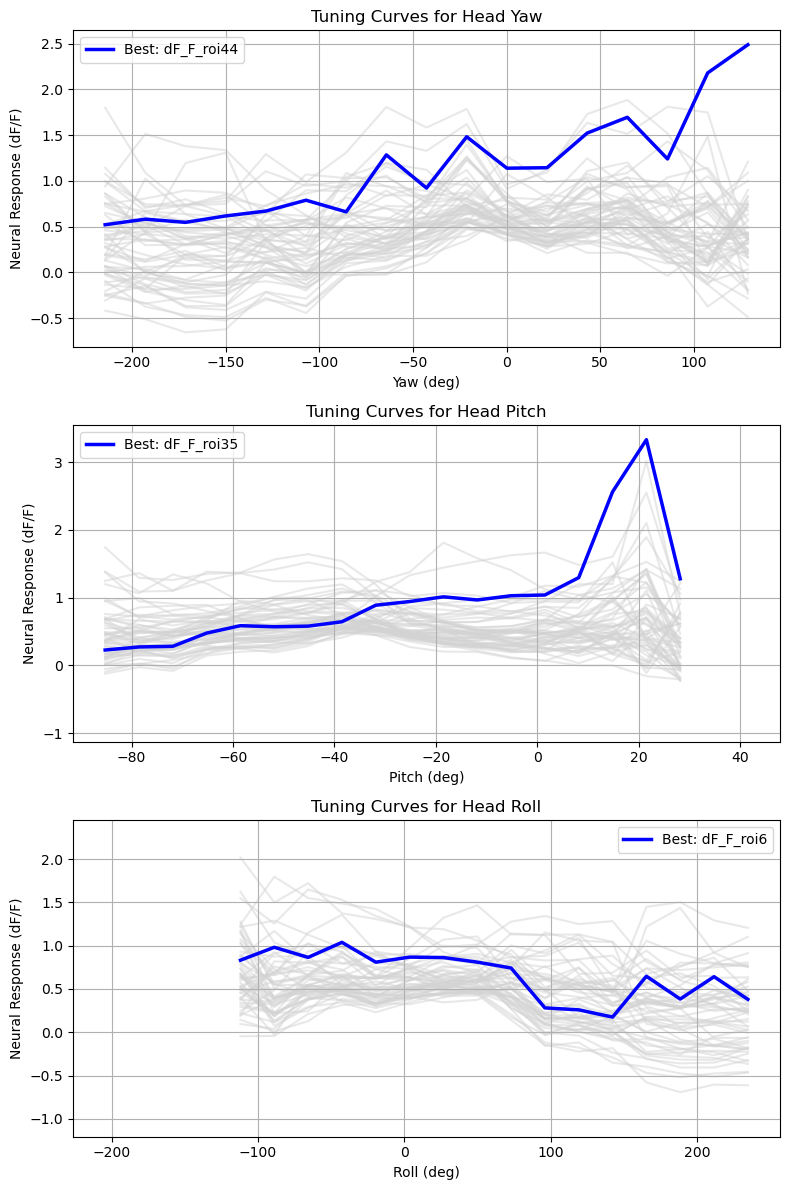

In [5]:
exclude_indices = [1,3,8,46,75,78,55,11,56, 18, 84, 10, 77, 76, 74, 7, 2, 9, 17, 10, 12, 14, 15, 16, 18, 19, 13, 17, 0, 20, 60, 63, 70, 79, ]  # List of numbers you want to exclude

# ------------------------
# 1. Detect Outlier Neurons
# ------------------------

# 1. Calculate the maximum dF/F for each neuron
neuron_max_vals = {neuron: df[neuron].max() for neuron in neural_columns}

# 2. Determine a threshold for outliers
max_array = np.array(list(neuron_max_vals.values()))
mean_max = np.mean(max_array)
std_max = np.std(max_array)

threshold = mean_max + 3 * std_max  # 3-sigma threshold
print("Max threshold for outlier detection:", threshold)

# 3. Identify outlier neurons
outlier_neurons = [neuron for neuron, val in neuron_max_vals.items() if val > threshold]
print("Outlier neurons detected:", outlier_neurons)

# --- NEW: Manually specify neurons to exclude based on additional sanity checks ---
# exclude_indices = [84, 10, 77]  # List of numbers you want to exclude
manual_excluded_neurons = [f'dF_F_roi{i}' for i in exclude_indices]

# 4. Remove outliers and manually excluded neurons from the neural_columns list
clean_neural_columns = [
    neuron for neuron in neural_columns 
    if (neuron not in outlier_neurons and neuron not in manual_excluded_neurons)
]
print("Neurons kept after outlier and manual exclusion:", clean_neural_columns)

# ------------------------
# 2. Compute and Select Best Neuron for Plotting
# ------------------------

def compute_tuning_curve(angle_vals, neural_vals, nbins=20):
    """
    Bin the angle values and compute the mean neural response within each bin.
    """
    bins = np.linspace(np.min(angle_vals), np.max(angle_vals), nbins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2.0
    avg_response = np.zeros(nbins)
    for i in range(nbins):
        mask = (angle_vals >= bins[i]) & (angle_vals < bins[i + 1])
        if np.any(mask):
            avg_response[i] = np.mean(neural_vals[mask])
        else:
            avg_response[i] = np.nan
    return bin_centers, avg_response

# Select the best neuron for each angle using tuning curve variance
best_neuron = {}
for angle_name, angle_vals in zip(['Yaw', 'Pitch', 'Roll'], [yaw_vals, pitch_vals, roll_vals]):
    best_metric = -np.inf
    selected_neuron = None
    for neuron in clean_neural_columns:
        neural_vals = df[neuron].values
        centers, tuning = compute_tuning_curve(angle_vals, neural_vals)
        metric = np.nanvar(tuning)
        if metric > best_metric:
            best_metric = metric
            selected_neuron = neuron
    best_neuron[angle_name] = selected_neuron

print("Best neurons for each angle after excluding outliers and manual exclusions:", best_neuron)

# ------------------------
# 3. Plot Tuning Curves
# ------------------------

fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=False)

angle_names = ['Yaw', 'Pitch', 'Roll']
angle_values_list = [yaw_vals, pitch_vals, roll_vals]

for ax, angle_name, angle_vals in zip(axes, angle_names, angle_values_list):
    # Plot all clean neurons in gray (background)
    for neuron in clean_neural_columns:
        neural_vals = df[neuron].values
        centers, tuning = compute_tuning_curve(angle_vals, neural_vals)
        ax.plot(centers, tuning, linestyle='-', color='lightgray', alpha=0.5, zorder=1)
    
    # Highlight the best neuron in color
    neuron = best_neuron[angle_name]
    neural_vals = df[neuron].values
    centers, tuning = compute_tuning_curve(angle_vals, neural_vals)
    ax.plot(centers, tuning, linestyle='-', color='blue', lw=2.5, label=f'Best: {neuron}', zorder=2)

    ax.set_title(f'Tuning Curves for Head {angle_name}')
    ax.set_xlabel(f'{angle_name} (deg)')
    ax.set_ylabel('Neural Response (dF/F)')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


Max threshold for outlier detection: 48.341670540972885
Outlier neurons detected: ['dF_F_roi48']
Neurons kept after outlier and manual exclusion: ['dF_F_roi4', 'dF_F_roi5', 'dF_F_roi6', 'dF_F_roi21', 'dF_F_roi22', 'dF_F_roi26', 'dF_F_roi27', 'dF_F_roi28', 'dF_F_roi29', 'dF_F_roi30', 'dF_F_roi31', 'dF_F_roi32', 'dF_F_roi33', 'dF_F_roi34', 'dF_F_roi35', 'dF_F_roi36', 'dF_F_roi37', 'dF_F_roi38', 'dF_F_roi39', 'dF_F_roi40', 'dF_F_roi41', 'dF_F_roi42', 'dF_F_roi43', 'dF_F_roi44', 'dF_F_roi45', 'dF_F_roi47', 'dF_F_roi49', 'dF_F_roi50', 'dF_F_roi51', 'dF_F_roi52', 'dF_F_roi53', 'dF_F_roi54', 'dF_F_roi57', 'dF_F_roi58', 'dF_F_roi59', 'dF_F_roi61', 'dF_F_roi64', 'dF_F_roi65', 'dF_F_roi66', 'dF_F_roi67', 'dF_F_roi69', 'dF_F_roi80', 'dF_F_roi81', 'dF_F_roi82', 'dF_F_roi83', 'dF_F_roi85', 'dF_F_roi86']
Best neurons for each angle after excluding outliers and manual exclusions: {'Yaw': 'dF_F_roi44', 'Pitch': 'dF_F_roi35', 'Roll': 'dF_F_roi6'}


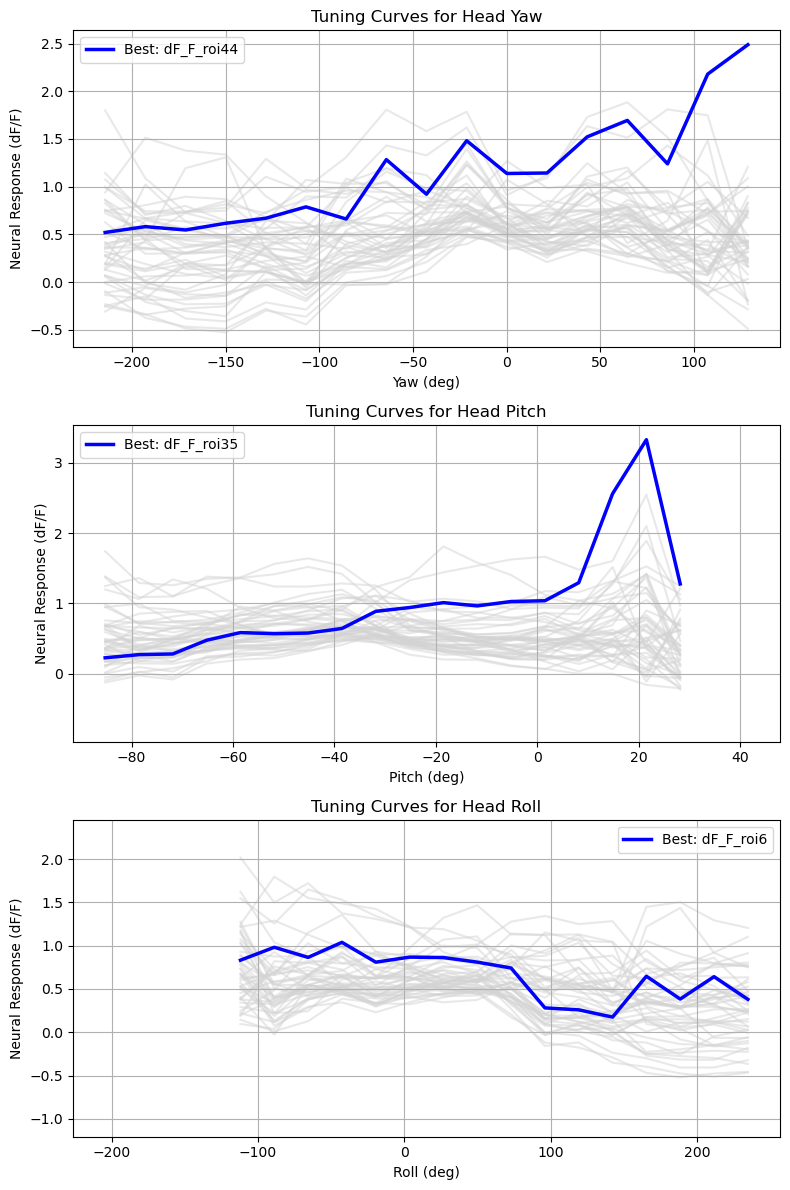

In [6]:
exclude_indices = [62,68,71,72,73,23, 24, 25, 1,3,8,46,75,78,55,11,56, 18, 84, 10, 77, 76, 74, 7, 2, 9, 17, 10, 12, 14, 15, 16, 18, 19, 13, 17, 0, 20, 60, 63, 70, 79, ]  # List of numbers you want to exclude

# ------------------------
# 1. Detect Outlier Neurons
# ------------------------

# 1. Calculate the maximum dF/F for each neuron
neuron_max_vals = {neuron: df[neuron].max() for neuron in neural_columns}

# 2. Determine a threshold for outliers
max_array = np.array(list(neuron_max_vals.values()))
mean_max = np.mean(max_array)
std_max = np.std(max_array)

threshold = mean_max + 3 * std_max  # 3-sigma threshold
print("Max threshold for outlier detection:", threshold)

# 3. Identify outlier neurons
outlier_neurons = [neuron for neuron, val in neuron_max_vals.items() if val > threshold]
print("Outlier neurons detected:", outlier_neurons)

# --- NEW: Manually specify neurons to exclude based on additional sanity checks ---
# exclude_indices = [84, 10, 77]  # List of numbers you want to exclude
manual_excluded_neurons = [f'dF_F_roi{i}' for i in exclude_indices]

# 4. Remove outliers and manually excluded neurons from the neural_columns list
clean_neural_columns = [
    neuron for neuron in neural_columns 
    if (neuron not in outlier_neurons and neuron not in manual_excluded_neurons)
]
print("Neurons kept after outlier and manual exclusion:", clean_neural_columns)

# ------------------------
# 2. Compute and Select Best Neuron for Plotting
# ------------------------

def compute_tuning_curve(angle_vals, neural_vals, nbins=20):
    """
    Bin the angle values and compute the mean neural response within each bin.
    """
    bins = np.linspace(np.min(angle_vals), np.max(angle_vals), nbins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2.0
    avg_response = np.zeros(nbins)
    for i in range(nbins):
        mask = (angle_vals >= bins[i]) & (angle_vals < bins[i + 1])
        if np.any(mask):
            avg_response[i] = np.mean(neural_vals[mask])
        else:
            avg_response[i] = np.nan
    return bin_centers, avg_response

# Select the best neuron for each angle using tuning curve variance
best_neuron = {}
for angle_name, angle_vals in zip(['Yaw', 'Pitch', 'Roll'], [yaw_vals, pitch_vals, roll_vals]):
    best_metric = -np.inf
    selected_neuron = None
    for neuron in clean_neural_columns:
        neural_vals = df[neuron].values
        centers, tuning = compute_tuning_curve(angle_vals, neural_vals)
        metric = np.nanvar(tuning)
        if metric > best_metric:
            best_metric = metric
            selected_neuron = neuron
    best_neuron[angle_name] = selected_neuron

print("Best neurons for each angle after excluding outliers and manual exclusions:", best_neuron)

# ------------------------
# 3. Plot Tuning Curves
# ------------------------

fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=False)

angle_names = ['Yaw', 'Pitch', 'Roll']
angle_values_list = [yaw_vals, pitch_vals, roll_vals]

for ax, angle_name, angle_vals in zip(axes, angle_names, angle_values_list):
    # Plot all clean neurons in gray (background)
    for neuron in clean_neural_columns:
        neural_vals = df[neuron].values
        centers, tuning = compute_tuning_curve(angle_vals, neural_vals)
        ax.plot(centers, tuning, linestyle='-', color='lightgray', alpha=0.5, zorder=1)
    
    # Highlight the best neuron in color
    neuron = best_neuron[angle_name]
    neural_vals = df[neuron].values
    centers, tuning = compute_tuning_curve(angle_vals, neural_vals)
    ax.plot(centers, tuning, linestyle='-', color='blue', lw=2.5, label=f'Best: {neuron}', zorder=2)

    ax.set_title(f'Tuning Curves for Head {angle_name}')
    ax.set_xlabel(f'{angle_name} (deg)')
    ax.set_ylabel('Neural Response (dF/F)')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
